In [1]:
import torch
from torch import nn
import torchtext

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from collections import defaultdict, Counter

import random
import time

## Data Preparation

In [2]:
def remove_empty_string(data_path, clean_data_path):
    with open(data_path, 'r') as f:
        data = f.read().splitlines()

    indexes_to_remove = []

    for i in range(len(data)-1):
        if (data[i] == '') and (data[i+1] == ''):
            indexes_to_remove.append(i)

    data = [elem for idx, elem in enumerate(data) if idx not in indexes_to_remove]

    with open(clean_data_path, 'w') as f:
        print(*data, file=f, sep='\n')
        
        
remove_empty_string('../data/genes.txt', '../data/clean_genes.txt')

In [3]:
def _subarray_search(array, subarray):
    """
    :param array: input array
    :param subarray: subarray to search in array
    :return: start and end indexes of subarray location in array
    """
    window = len(subarray)
    indexes = []
    for i in range(len(array) - window):
        current = array[i:i + window]
        if ' '.join(subarray) in ' '.join(current):
            indexes.append((i, i + len(subarray) - 1))
    return indexes


def to_conll(data_path, save_data_path):
    with open(data_path, 'r') as f:
        data = f.read().splitlines()

    texts = []
    labels = []
    example = []
    for string in data:
        if string:
            example.append(string)
        else:
            text = example[0].split('||')[-1]
            texts.append(text)

            genes = [elem.split()[:-1] for elem in example[1:]]
            window_size = len(sorted(genes, key=len)[-1])
            tag_sequence = ['O' for _ in range(len(text.split()))]
            for gene in genes:
                ids = _subarray_search(text.split(), gene)
                for start_id, end_id in ids:
                    tag_sequence[start_id] = 'B-GENE'
                    for i in range(start_id+1, end_id+1):
                        tag_sequence[i] = 'I-GENE'
            labels.append(' '.join(tag_sequence))
            example = []
     
    with open(save_data_path, 'w') as f:
        for i in range(len(texts)):
            text = texts[i]
            label = labels[i]
            for (x, y) in zip(text.split(), label.split()):
                f.write(x + ' ' + y + '\n')
            f.write('\n')
            

to_conll('../data/clean_genes.txt', '../data/conll_genes.txt')

In [4]:
def read_data(corpus_file, datafields):
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        texts = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append(torchtext.data.Example.fromlist([texts, labels], datafields))
                texts = []
                labels = []
            else:
                columns = line.split()
                texts.append(columns[0])
                labels.append(columns[-1])
        return torchtext.data.Dataset(examples, datafields)

## Model

In [5]:
class RNNTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)
        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)

        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
 
    def compute_outputs(self, sentences):      
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)

        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        return out
                
    
    def forward(self, sentences, labels):
        scores = self.compute_outputs(sentences)
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    
    def predict(self, sentences):
        scores = self.compute_outputs(sentences)
        predicted = scores.argmax(dim=2)
        return predicted.t().cpu().numpy()

## Utils functions

In [6]:
def to_spans(l_ids, voc):
    spans = {}
    current_label = None
    current_start = None
    for i, label_id in enumerate(l_ids):
        label = voc[label_id]

        if label[0] == 'B': 
            if current_label:
                spans[current_start] = (current_label, i)
            current_label = label[2:]
            current_start = i
        elif label[0] == 'I':
            if current_label:
                if current_label != label[2:]:
                    spans[current_start] = (current_label, i)
                    current_label = label[2:]
                    current_start = i
            else:
                current_label = label[2:]
                current_start = i
        else:
            if current_label:
                spans[current_start] = (current_label, i)
                current_label = None
                current_start = None
    return spans

def compare(gold, pred, stats):
    for start, (label, end) in gold.items():
        stats['total']['gold'] += 1
        stats[label]['gold'] += 1
    for start, (label, end) in pred.items():
        stats['total']['pred'] += 1
        stats[label]['pred'] += 1
    for start, (gold_label, gold_end) in gold.items():
        if start in pred:
            pred_label, pred_end = pred[start]
            if gold_label == pred_label and gold_end == pred_end:
                stats['total']['corr'] += 1
                stats[gold_label]['corr'] += 1

def evaluate_iob(predicted, gold, label_field, stats):
    gold_cpu = gold.t().cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    pred_cpu = [l for sen in predicted for l in sen]

    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    compare(gold_spans, pred_spans, stats)

def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

## Pipeline

In [7]:
class GenePipeline:
    
    def __init__(self, n_epochs, batch_size, lower=False):
        self.TEXT = torchtext.data.Field(init_token='<sos>', eos_token='<eos>', sequential=True, lower=lower)
        self.LABEL = torchtext.data.Field(init_token='<sos>', eos_token='<eos>', sequential=True, unk_token=None)
        self.fields = [('text', self.TEXT), ('label', self.LABEL)]
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.device = 'cpu'
        
    def inference(self, sentences):
        examples = []
        for sen in sentences:
            labels = ['O']*len(sen)
            examples.append(torchtext.data.Example.fromlist([sen, labels], self.fields))
        dataset = torchtext.data.Dataset(examples, self.fields)
        
        iterator = torchtext.data.Iterator(
            dataset,
            device=self.device,
            batch_size=1,
            repeat=False,
            train=False,
            sort=False)
        
        out = []
        self.model.eval()
        with torch.no_grad():
            for batch in iterator:
                predicted = self.model.predict(batch.text)

                for tokens, pred_sen in zip(sentences, predicted):
                    out.append([self.LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
        return out
                
    def train(self, train_data_path, val_data_path):
        train_examples = read_data(train_data_path, self.fields)
        valid_examples = read_data(val_data_path, self.fields)

        n_tokens_train = 0
        n_sentences_train = 0
        for ex in train_examples:
            n_tokens_train += len(ex.text) + 2
            n_sentences_train += 1
        n_tokens_valid = 0       
        
        for ex in valid_examples:
            n_tokens_valid += len(ex.text)

        self.TEXT.build_vocab(train_examples, max_size=5000)
        self.LABEL.build_vocab(train_examples)
    
        self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128)
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-5)
    
        n_batches = np.ceil(n_sentences_train / self.batch_size)
        mean_n_tokens = n_tokens_train / n_batches

        train_iterator = torchtext.data.BucketIterator(
            train_examples,
            device=self.device,
            batch_size=self.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=True,
            sort=True)

        valid_iterator = torchtext.data.BucketIterator(
            valid_examples,
            device=self.device,
            batch_size=self.batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=False,
            sort=True)
    
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)
        n_labels = len(self.LABEL.vocab)
        history = defaultdict(list)    
        
        for i in range(1, self.n_epochs + 1):
            t0 = time.time()
            loss_sum = 0
            self.model.train()
            
            #Training
            for batch in train_batches:
                loss = self.model(batch.text, batch.label) / mean_n_tokens
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / n_batches
            history['train_loss'].append(train_loss)

            # Validation
            stats = defaultdict(Counter)

            self.model.eval()
            with torch.no_grad():
                #Т.к. в этом задании обучение=валидация, то не будем записывать лосс на валидации
                for batch in valid_batches:
                    predicted = self.model.predict(batch.text)                   
                    evaluate_iob(predicted, batch.label, self.LABEL, stats)

            _, _, val_f1 = prf(stats['total'])

            history['val_f1'].append(val_f1)

            t1 = time.time()
            print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        print()
        print('Final evaluation on the validation set:')
        p, r, f1 = prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = prf(stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        fig = plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'])
        plt.legend(['training loss'])
        
        plt.subplot(1, 2, 2)
        plt.plot(history['val_f1'], color='orange')
        plt.legend(['val F1-score'])

Epoch 1: train loss = 1.3401, val f1: 0.0000, time = 0.6128
Epoch 2: train loss = 0.4961, val f1: 0.1636, time = 0.5799
Epoch 3: train loss = 0.3295, val f1: 0.5600, time = 0.6056
Epoch 4: train loss = 0.1692, val f1: 0.7647, time = 0.5776
Epoch 5: train loss = 0.0880, val f1: 0.8649, time = 0.5580

Final evaluation on the validation set:
Overall: P = 0.8421, R = 0.8889, F1 = 0.8649
GENE: P = 0.8421, R = 0.8889, F1 = 0.8649


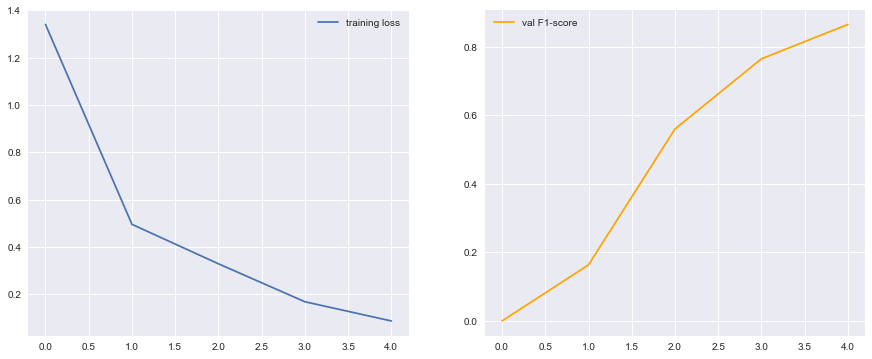

In [8]:
n_epochs = 5
batch_size = 13

tagger = GenePipeline(n_epochs=n_epochs, batch_size=batch_size)
tagger.train('../data/conll_genes.txt', '../data/conll_genes.txt')

In [9]:
def print_tags(sentence):
    tokens = sentence.split()
    tags = tagger.inference([tokens])[0]
    for token, tag in zip(tokens, tags):
        print(f'{token:15s}{tag}')

In [10]:
print_tags('Interaction of the v - rel protein with an NF - kappa B DNA binding site .')

Interaction    O
of             O
the            O
v              B-GENE
-              I-GENE
rel            I-GENE
protein        I-GENE
with           O
an             O
NF             B-GENE
-              I-GENE
kappa          I-GENE
B              I-GENE
DNA            O
binding        O
site           O
.              O
